# 🎯 Uplift modeling `metrics`

<br>
<center>
    <a href="https://colab.research.google.com/github/maks-sh/scikit-uplift/blob/master/notebooks/uplift_metrics_tutorial.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg">
    </a>
    <br>
    <b><a href="https://github.com/maks-sh/scikit-uplift/">SCIKIT-UPLIFT REPO</a> | </b>
    <b><a href="https://scikit-uplift.readthedocs.io/en/latest/">SCIKIT-UPLIFT DOCS</a> | </b>
    <b><a href="https://scikit-uplift.readthedocs.io/en/latest/user_guide/index.html">USER GUIDE</a></b>
    <br>
</center>

In [113]:
import sys

# install uplift library scikit-uplift and other libraries 
# !{sys.executable} -m pip install scikit-uplift dill catboost

# data loading

In [114]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re

In [115]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [116]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [ ]:
X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
for df in [X_train, X_test]:
    df = clean_column_names(df)
y_train = train["churn"].astype(int)
treatment_train = train["outreach"].astype(int)

y_test = test["churn"].astype(int)
treatment_test = test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)
y_test=x_test
y_train=x_train
treatment_test=treatment_train
# Choose uplift method (two-model vs meta-learner S-learner)
uplift_method = config.get("uplift_method", "two_model")
models_dir = os.path.join(repo_root, "models")
os.makedirs(models_dir, exist_ok=True)
outputs_dir = os.path.join(repo_root, "outputs")
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

Aggregating train features...
Aggregating test features...
Training data: 10000 samples; test data: 10000 samples

Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


In [118]:
from datetime import datetime

In [119]:
# dataset = fetch_megafon()
# data, treatment, target = dataset.data, dataset.treatment, dataset.target
# data = data.set_index('id')
X_train.drop(columns=["outreach"], inplace=True)
X_test.drop(columns=["outreach"], inplace=True)
X_train.head()

C:\Users\elad\AppData\Local\Temp\ipykernel_11052\3304880680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["outreach"], inplace=True)
C:\Users\elad\AppData\Local\Temp\ipykernel_11052\3304880680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns=["outreach"], inplace=True)


,days_already_on_app,session_count,web_visit_count,claims_count,has_E11_9,has_I10,has_Z71_3
0,445,6.0,3.0,9.0,1.0,1.0,1.0
1,112,10.0,9.0,9.0,1.0,1.0,1.0
2,277,9.0,52.0,4.0,1.0,0.0,0.0
3,441,10.0,15.0,5.0,0.0,1.0,0.0
4,476,10.0,11.0,7.0,1.0,1.0,1.0


# 📝 Load data

We are going to use a `Lenta dataset` from the BigTarget Hackathon hosted in summer 2020 by Lenta and Microsoft.

Lenta is a russian food retailer. 

### Data description

✏️ Dataset can be loaded from `sklift.datasets` module using `fetch_lenta` function.

Read more about dataset <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html">in the api docs</a>.  

This is an uplift modeling dataset containing data about Lenta's customers grociery shopping, marketing campaigns communications as `treatment` and store visits as `target`.

####  ✏️ Major columns:

- `group` - treatment / control flag
- `response_att` - binary target
- `CardHolder` - customer id
- `gender` - customer gender 
- `age` - customer age

In [120]:
from sklift.datasets import fetch_lenta



# 📝 EDA

### 🤔 target share for `treatment / control` 

In [121]:
import pandas as pd 

pd.crosstab(treatment_train, y_train, normalize='index')

churn,0,1
outreach,,
0,0.792553,0.207447
1,0.805974,0.194026


### ✂️ train test split

- stratify by two columns: treatment and target. 

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one. 

In [122]:
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_test.shape}")

Train shape: (10000, 7)
Validation shape: (10000, 7)


# 👾 Class Transformation uplift model

`Class transformation` method is described <a href="https://www.uplift-modeling.com/en/latest/user_guide/models/revert_label.html"> here</a>  

Class transormation method `may` be used in case of treatment unbalanced data. In this case one will get not an uplift score but some *ranking* score still useful for ranking objects.

In [123]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100, 
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [124]:
ct_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=treatment_train
)

Learning rate set to 0.027538
0:	learn: 0.6921419	total: 3.85ms	remaining: 3.84s
100:	learn: 0.6647312	total: 342ms	remaining: 3.04s
200:	learn: 0.6560313	total: 674ms	remaining: 2.68s
300:	learn: 0.6486417	total: 1.01s	remaining: 2.36s
400:	learn: 0.6411378	total: 1.43s	remaining: 2.13s
500:	learn: 0.6329659	total: 1.79s	remaining: 1.78s
600:	learn: 0.6256301	total: 2.14s	remaining: 1.42s
700:	learn: 0.6193341	total: 2.53s	remaining: 1.08s
800:	learn: 0.6130072	total: 2.87s	remaining: 714ms
900:	learn: 0.6069574	total: 3.24s	remaining: 356ms
999:	learn: 0.6009803	total: 3.58s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x000001CBCCA297B0>)

### Save model

In [125]:
import dill

with open("model.dill", 'wb') as f:
    dill.dump(ct_model, f)

### Uplift prediction

In [126]:
uplift_ct = ct_model.predict(X_test)
uplift_ct

array([-0.06718653,  0.08804766,  0.25613436, ...,  0.30707602,
        0.48449143,  0.07546137])

# 🚀🚀🚀 Uplift metrics

##  🚀 `uplift@k`

- uplift at first k%
- usually falls between [0; 1] depending on k, model quality and data


### `uplift@k` = `target mean at k% in the treatment group` - `target mean at k% in the control group`

___

How to count `uplift@k`:

1. sort by predicted uplift
2. select first k%
3. count target mean in the treatment group
4. count target mean in the control group
5. substract the mean in the control group from the mean in the treatment group

---

Code parameter options:

- `strategy='overall'` - sort by uplift treatment and control together
- `strategy='by_group'` - sort by uplift treatment and control separately

In [127]:
from sklift.metrics import uplift_at_k

# k = 10%
k = 0.1  

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(y_test, uplift_ct, treatment_test, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(y_test, uplift_ct, treatment_test, strategy='by_group', k=k)

print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@10%: 0.0014 (sort groups by uplift together)
uplift@10%: -0.0243 (sort groups by uplift separately)


## 🚀 `uplift_by_percentile` table

Count metrics for each percentile in data in descending order by uplift prediction (by rows):

- `n_treatment` - treatment group size in the one percentile
- `n_control` - control group size in the one percentile
- `response_rate_treatment` -  target mean in the treatment group in the one percentile
- `response_rate_control` - target mean in the control group in the one percentile
- `uplift = response_rate_treatment - response_rate_control` in the one percentile

___

Code parameter options are:

- `strategy='overall'` - sort by uplift treatment and control groups together
- `strategy='by_group'` - sort by uplift treatment and control groups separately
- `total=True` - show total metric on full data
- `std=True` - show metrics std by row 

In [128]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    0
9999    0
Name: churn, Length: 10000, dtype: int32

In [129]:
# from sklift.metrics import uplift_by_percentile

# uplift_by_percentile(y_test, uplift_ct, treatment_test, 
#                      strategy='overall', 
#                      total=True, std=True, bins=10)

## 🚀 `weighted average uplift `

- counts uplift on full data
- uses results from `uplift_by_percentile` table
- result depends on number of bins

### `weighted average uplift` = `sum of uplift by percentile weighted on the treatment group size`


In [130]:
from sklift.metrics import weighted_average_uplift

uplift_full_data = weighted_average_uplift(y_test, uplift_ct, treatment_test, bins=10) 
print(f"average uplift on full data: {uplift_full_data:.4f}")

average uplift on full data: -0.0194


## 🚀 `uplift_by_percentile` plot

- visualize results of `uplift_by_percentile` table

Two ways to plot:

- line plot `kind='line'`
- bar plot `kind='bar'`


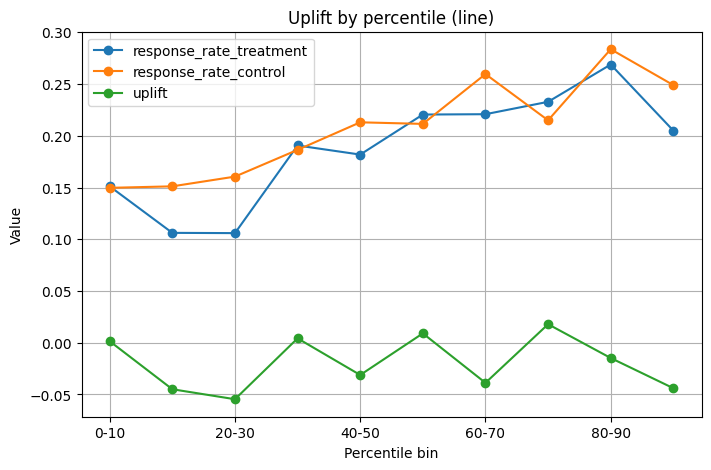

In [131]:
# Instead of calling the viz helper directly (which can fail if the
# returned table contains non-scalar cells), compute the percentile table
# and plot only numeric columns to avoid the "setting an array element
# with a sequence" error.
from sklift.metrics import uplift_by_percentile
import matplotlib.pyplot as plt

# compute table (returns pd.DataFrame)
ubp = uplift_by_percentile(
    y_test,
    uplift_ct,
    treatment_test,
    strategy="overall",
    total=False,
    std=False,
    bins=10,
)

# prefer these named columns if present, otherwise plot all numeric columns
preferred = ["response_rate_treatment", "response_rate_control", "uplift"]
plot_cols = [c for c in preferred if c in ubp.columns]
if not plot_cols:
    plot_cols = ubp.select_dtypes(include="number").columns.tolist()

ax = ubp[plot_cols].plot(kind="line", marker="o", figsize=(8, 5))
ax.set_title("Uplift by percentile (line)")
ax.set_xlabel("Percentile bin")
ax.set_ylabel("Value")
ax.grid(True)
plt.show()

In [132]:
# # bar plot
# plot_uplift_by_percentile(y_test, uplift_ct, treatment_test, strategy='overall', kind='bar')

## 🚀  `Qini curve` 

The curve plots the absolute incremental outcome of the treated group compared to group with no treatment. 


plot Qini curve: 
- `blue line` is a `real Qini curve` based on data.
- `red line` is an `ideal Qini curve` based on data. Code: `perfect=True`
- `grey line` is a `random Qini curve` based on data
    

## 🚀 `AUQC` (`area under Qini curve` or `Qini coefficient`)

`Qini coefficient` = `light blue area between the real Qini curve and the random Qini curve normalized on area between the random and the ideal line`

<img src="https://habrastorage.org/getpro/habr/upload_files/18a/f90/b30/18af90b30dbdff84e1b3a8ab77195101.png" width="400" alt="qini_curve">


- metric is printed at the title of the Qini curve plot
- can be called as a separate function

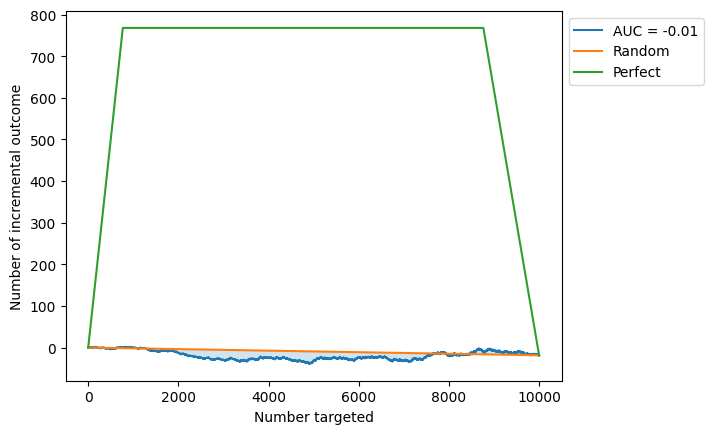

In [133]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_ct, treatment_test, perfect=True);

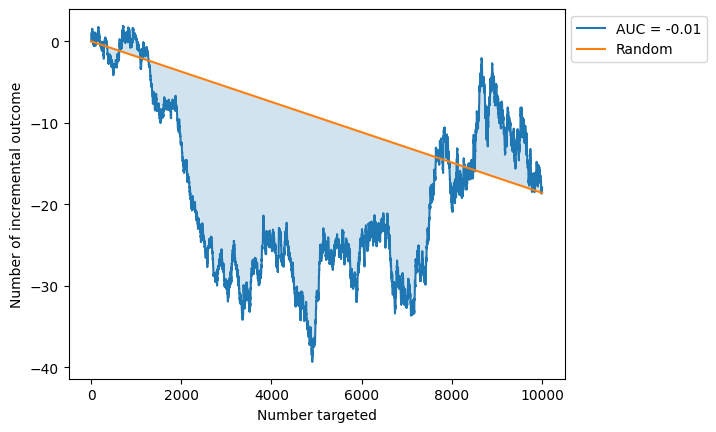

In [134]:
# no ideal Qini curve
# only real Qini curve
# perfect=False
plot_qini_curve(y_test, uplift_ct, treatment_test, perfect=False);

In [135]:
from sklift.metrics import qini_auc_score

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_ct, treatment_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: -0.0135


## 🚀 `Uplift curve` 

The Uplift curve plots incremental uplift.


   - `blue line` is a `real Uplift curve` based on data. 
   - `red line` is an `ideal Uplift curve` based on data. Code: `perfect=True`
   - `grey line` is a `random Uplift curve` based on data.
    

## 🚀 `AUUQ` (`area under uplift curve`)

- `Area under uplift curve` = blue area between the real Uplift curve and the random Uplift curve 
    - appears at the title of the Uplift curve plot
    - can be called as a separate function


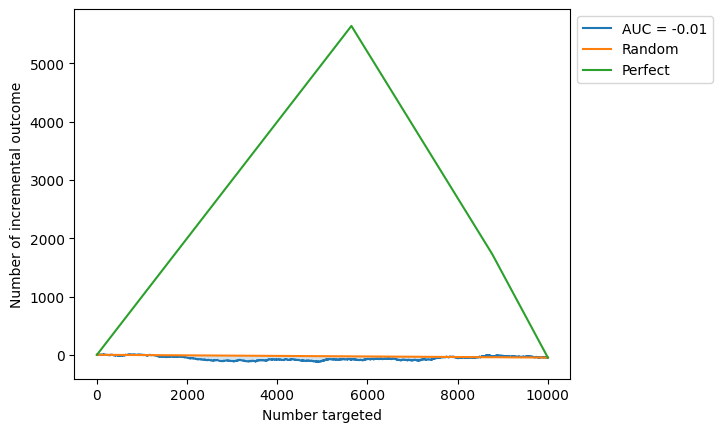

In [136]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_test, uplift_ct, treatment_test, perfect=True);

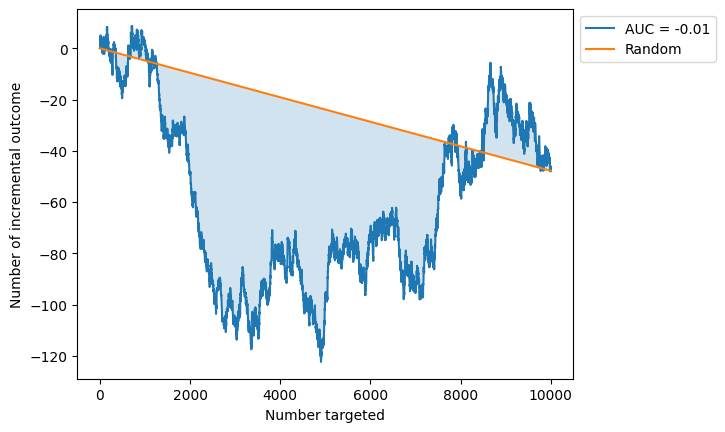

In [137]:
# only real
# perfect=False
plot_uplift_curve(y_test, uplift_ct, treatment_test, perfect=False);

In [138]:
from sklift.metrics import uplift_auc_score

# AUUQ = area under uplift curve
auuc = uplift_auc_score(y_test, uplift_ct, treatment_test) 
print(f"Uplift auc score on full data: {auuc:.4f}")

Uplift auc score on full data: -0.0123


In [139]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    0
9999    0
Name: churn, Length: 10000, dtype: int32